In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import glob
import os
import matplotlib.pyplot as plt
import math

#Umap
import matplotlib.pyplot as plt
from umap.umap_ import UMAP

from pointgrid import align_points_to_grid

# t-SNE
from sklearn.manifold import TSNE

#hdbscan
import hdbscan

In [2]:
# Import
path_in = 'data/csv/freihand_signatures.csv'

df = pd.read_csv(path_in)
df = df.fillna('')

# Filter out the rows with missing values
df_filtered = df[df.inventory_year != '']

# 10'000 sample points for fast plotting
df = df.sample(10000)
df_filtered = df_filtered.sample(10000)

# Tokenization

In [3]:
# text cols for wordclouds, cluster cols for clustering
text_cols = ['text', 'text_3', 'text_2', 'text_1']
cluster_cols = ['sig_lev_1', 'sig_lev_2', 'sys']

# Perform one-hot encoding on the cluster_cols
df_cluster = pd.get_dummies(df[cluster_cols])
df_cluster_filtered = pd.get_dummies(df_filtered[cluster_cols])


# Functions

In [1]:
# Normalize 
def normalize(emb):

    embedding = emb * 100 # Multiply by 100
    embedding = align_points_to_grid(embedding)

    # Swap axes for horizontal position

    ptp = np.ptp(embedding, axis=0)
    if ptp[1]> ptp[0]:
        embedding[:, [1, 0]] = embedding[:, [0, 1]]

    # Set range of values normalized to dimension with higher extent

    extent = (embedding[:,0].min(), embedding[:,0].max()) if (embedding[:,0].max() - embedding[:,0].min()) > (embedding[:,1].max() - embedding[:,1].min()) else (embedding[:,1].min(), embedding[:,1].max())
    resolution = (-1000, 1000)

    embedding[:, 0] = np.interp(embedding[:,0], extent, resolution)
    embedding[:, 1] = np.interp(embedding[:,1], extent, resolution)

    # # Set origin at the middle

    # ptp = np.ptp(embedding, axis=0)  
    # embedding[:, 0] = embedding[:, 0] - ptp[0] / 2
    # embedding[:, 1] = embedding[:, 1] - ptp[1] / 2

    embedding = embedding.astype(int) # Set integer

    return embedding

In [51]:

def plot_embeddings(embeddings, param_names, num_cols = 2):
    # Create a subplot grid for the scatterplots
    num_plots = len(embeddings)
    num_cols = num_cols
    num_rows = (num_plots + num_cols - 1) // num_cols
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
    axs = axs.flatten()

    for i, (object, embedding) in enumerate(embeddings):
        # Normalize and plot the embedding
        embedding = normalize(embedding)

        # Create a scatterplot
        sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=df.signature.astype(str).str[0], hue_order=order, ax=axs[i], s=10)

        # Set the title of the plot based on the specified parameters
        title_params = {param_name: getattr(object, param_name) for param_name in param_names}
        title_str = ', '.join(f'{param_name}: {title_params[param_name]}' for param_name in param_names)
        axs[i].set_title(title_str)

    # Show the scatterplots
    plt.show()


def plot_embeddings_year(embeddings, param_names, df, num_cols = 2):
    # Create a subplot grid for the scatterplots
    num_plots = len(embeddings)
    num_cols = num_cols
    num_rows = (num_plots + num_cols - 1) // num_cols
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
    axs = axs.flatten()

    for i, (object, embedding) in enumerate(embeddings):
        # Normalize and plot the embedding
        embedding = normalize(embedding)

        # hue
        order = sorted([(f'{year}0') for year in df.inventory_year.astype(str).str[:3].unique().tolist()])
        colours = sns.color_palette("coolwarm", n_colors=len(order))
        hue = df.inventory_year.astype(str).str[:3].map(lambda x:  f'{x}0')

        sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=hue, hue_order=order, ax=axs[i], s=10, palette=colours)

        # Set the title of the plot based on the specified parameters
        title_params = {param_name: getattr(object, param_name) for param_name in param_names}
        title_str = ', '.join(f'{param_name}: {title_params[param_name]}' for param_name in param_names)
        axs[i].set_title(title_str)

    # Show the scatterplots
    plt.show()


# UMAP

In [130]:
%%time

metrics = ['hamming'] #distance metric : hamming/jaccard good for categorical data
neighbors = [100, 400] #balances local versus global structure
min_dist = [0.1, 0.5] #how tightly are points allowed to be packed together, low values mean tighter packing/clustering possible

embeddings = []

for k, metric in enumerate(metrics):
    for i, neighbor in enumerate(neighbors):
        for j, dist in enumerate(min_dist):
            
            umap_obj = UMAP(n_components=2, n_neighbors=neighbor, metric=metric, min_dist=dist, 
                                 spread=1.0, random_state=42, verbose=False)
            x_umap = umap_obj.fit_transform(df_cluster)

            embeddings.append((umap_obj, x_umap))       

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


CPU times: user 35min 11s, sys: 31.7 s, total: 35min 42s
Wall time: 19min 1s


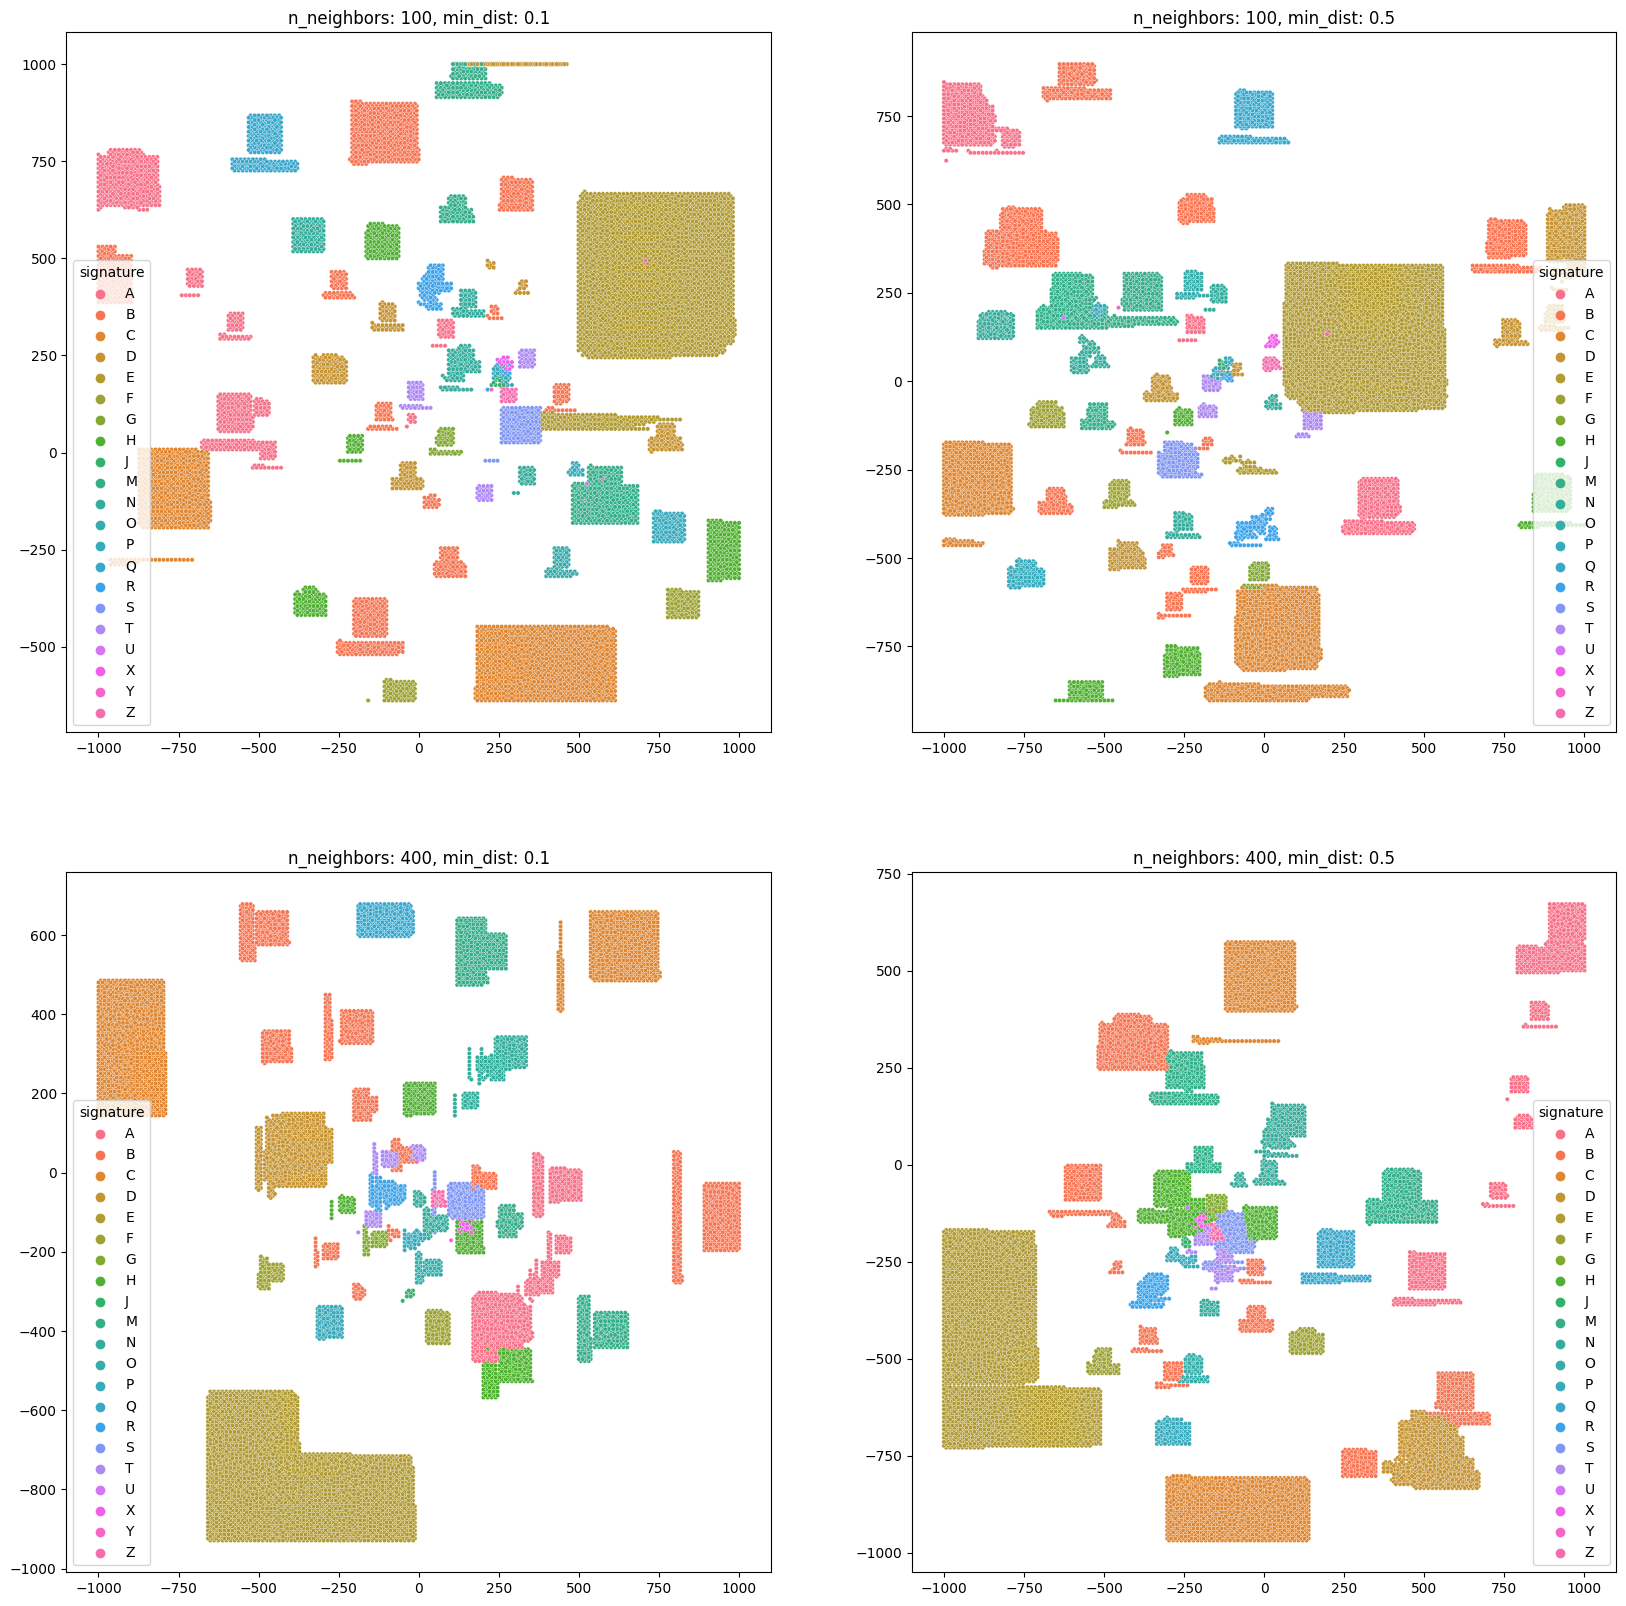

In [136]:
plot_embeddings(embeddings, ['n_neighbors', 'min_dist'], 2)
    

# Tsne

In [165]:
metrics= ['euclidean']
perplexities = [200, 400, 800] #balancing global versus local structure. Needs to be higher for larger datasets. approx 500 for 10'000 datapoints
learning_rates = [100, 200, 400] #

embeddings = []
for metric in metrics: 
    for i, perplexity in enumerate(perplexities):
        for j, learning_rate in enumerate(learning_rates):

            tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=1000, metric=metric, init= 'random')
            x_tsne = tsne.fit_transform(df_cluster)

            embeddings.append((tsne, x_tsne))  
    

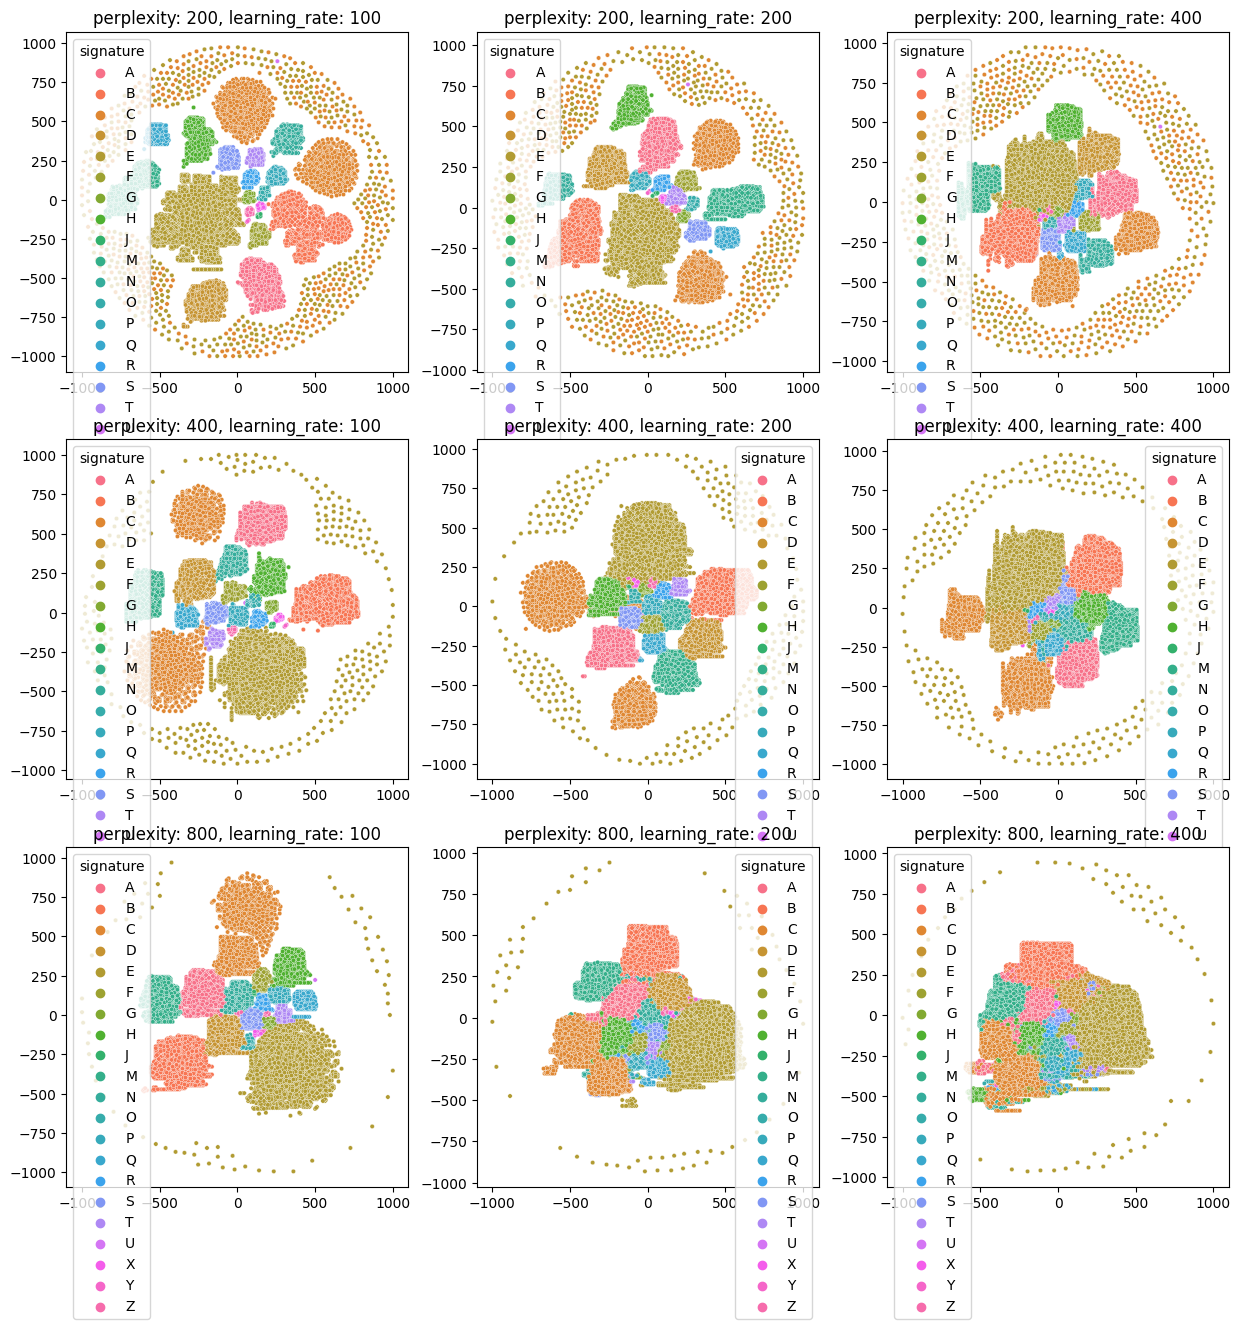

In [166]:
plot_embeddings(embeddings, ['perplexity', 'learning_rate'], 3)

# Plotting By year

# UMAP

In [188]:
%%time

metrics = ['hamming'] #distance metric : hamming/jaccard good for categorical data
neighbors = [100, 400] #balances local versus global structure
min_dist = [0.1, 0.5] #how tightly are points allowed to be packed together, low values mean tighter packing/clustering possible

embeddings = []

for k, metric in enumerate(metrics):
    for i, neighbor in enumerate(neighbors):
        for j, dist in enumerate(min_dist):
            
            umap_obj = UMAP(n_components=2, n_neighbors=neighbor, metric=metric, min_dist=dist, 
                                 spread=1.0, random_state=42, verbose=False)
            x_umap = umap_obj.fit_transform(df_cluster_filtered)

            embeddings.append((umap_obj, x_umap))

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


CPU times: user 36min 18s, sys: 34.5 s, total: 36min 52s
Wall time: 19min 28s


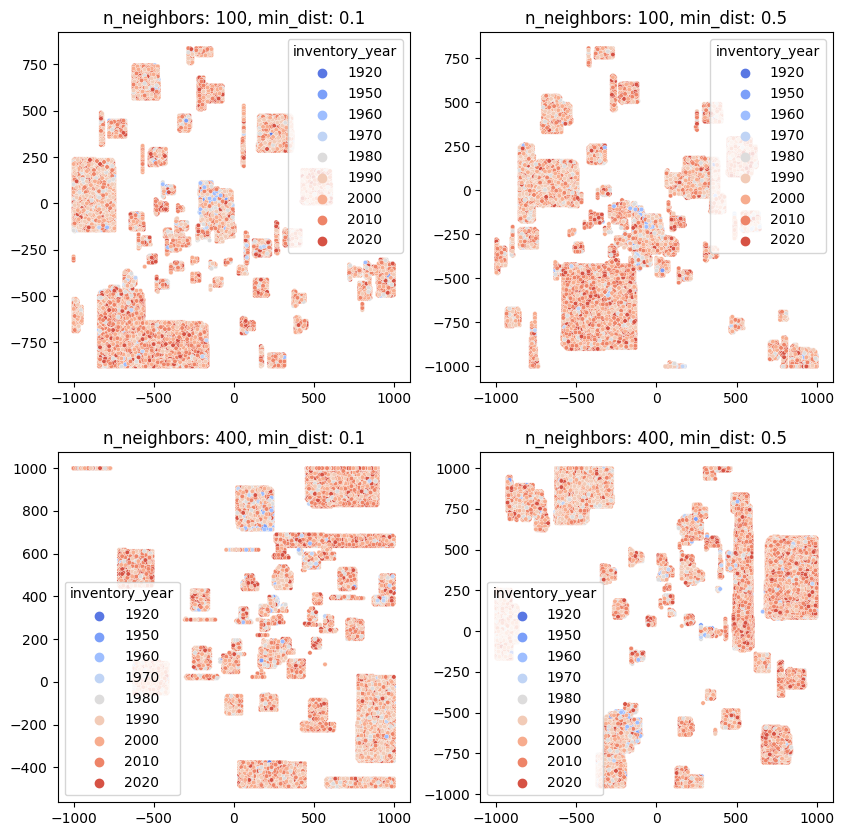

In [190]:
plot_embeddings_year(embeddings, ['n_neighbors', 'min_dist'], df_filtered, 2)


# TSNE

In [184]:
metrics= ['euclidean']
perplexities = [200, 400, 800] #balancing global versus local structure. Needs to be higher for larger datasets. approx 500 for 10'000 datapoints
learning_rates = [100, 200, 400] #

embeddings = []
for metric in metrics: 
    for i, perplexity in enumerate(perplexities):
        for j, learning_rate in enumerate(learning_rates):

            tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=1000, metric=metric, init= 'random')
            x_tsne = tsne.fit_transform(df_cluster_filtered)

            embeddings.append((tsne, x_tsne))  
    

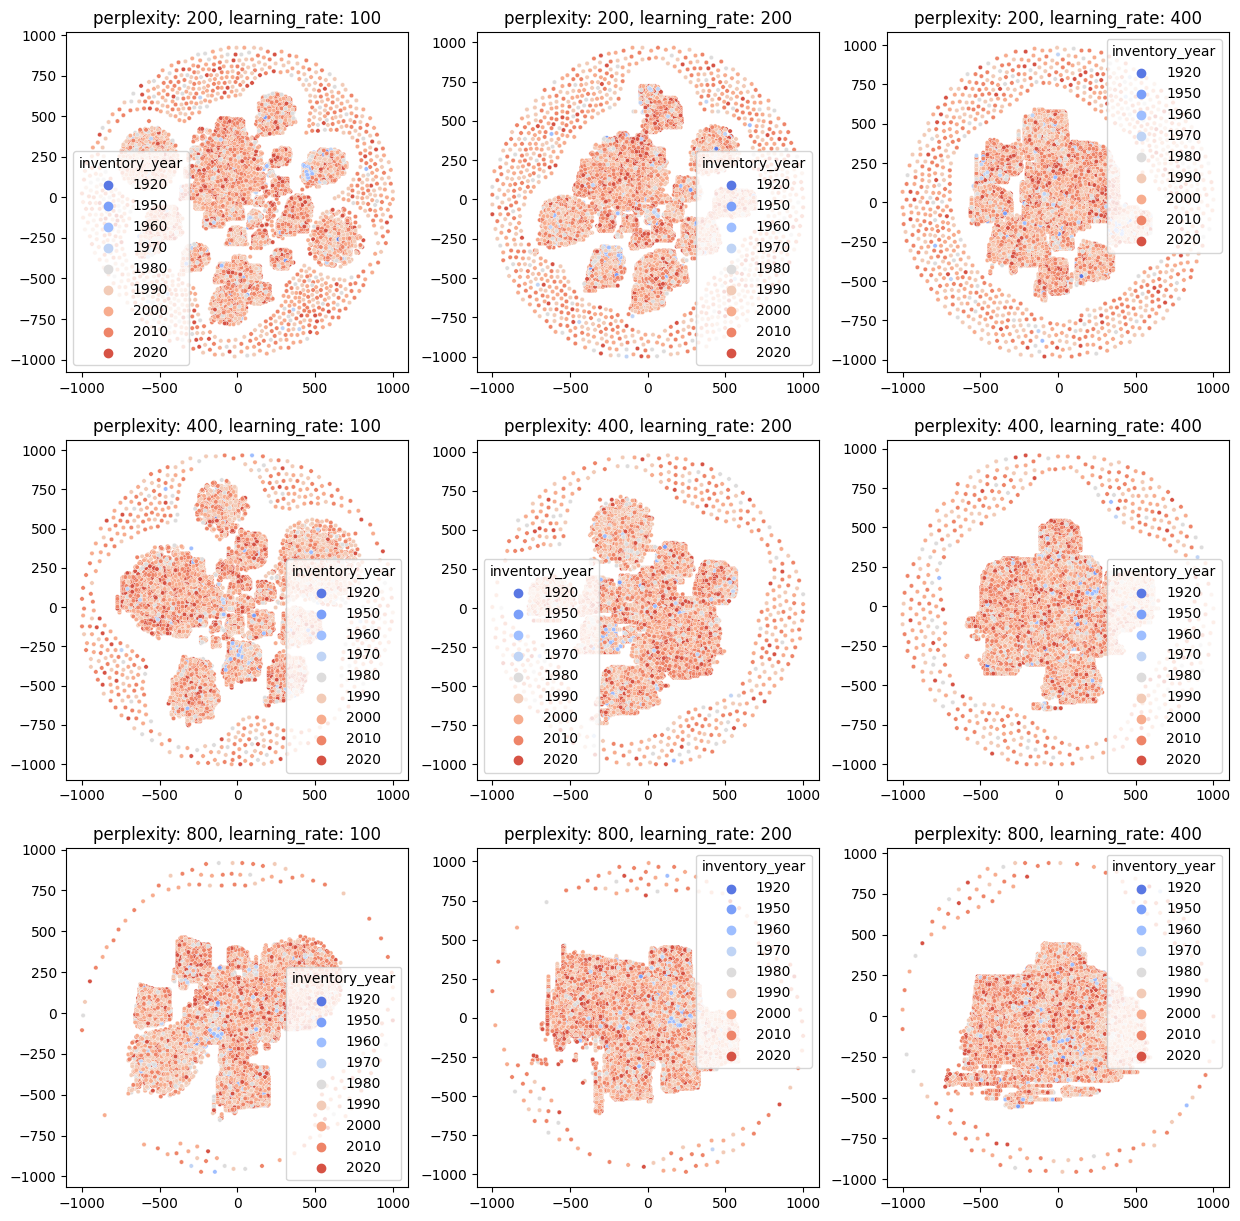

In [187]:
plot_embeddings_year(embeddings, ['perplexity', 'learning_rate'],df_filtered, 3)